[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mund99/Financial_Price_Forecasting/blob/main/ARIMA_model.ipynb)

# Model.py

In [1]:
import warnings
import pandas as pd
import statsmodels.api as sm

import time
import numpy as np
from sklearn import metrics

def grid_search_arima(train_data, p_values, q_values):
    """
    Perform a grid search to find the best ARIMA orders (p, q) that minimize MAE on the training data.

    Parameters:
        train_data (pd.Series): The training time series data.
        p_values (list): List of p values to explore.
        q_values (list): List of q values to explore.

    Returns:
        int: Best p value.
        int: Best q value.
        dict: MAE values for different p and q combinations.
    """
    mae_grid = {}  # Initialize an empty dictionary

    # Initialize best_p and best_q
    best_p = None
    best_q = None
    best_mae = float('inf')

    # Loop through different pairs of p and q
    for p in p_values:
        mae_grid[p] = []  # Initialize a list for each p value
        for q in q_values:
            start_time = time.time()

            # Train an ARIMA model
            order = (p, 1, q)
            model = sm.tsa.ARIMA(train_data.values, order=order).fit()

            elapsed_time = round(time.time() - start_time, 2)

            # Make predictions on the training data
            y_pred = model.fittedvalues

            # Calculate MAE for this pair of p and q
            mae = metrics.mean_absolute_error(train_data.values, y_pred).round(4)
            mae_grid[p].append(mae)

            # Check if this model has the lowest MAE so far
            if mae < best_mae:
                best_mae = mae
                best_p = p
                best_q = q

            print("Order = {}, MAE={}, Elapsed Time={} seconds".format(order, mae, elapsed_time))

    return best_p, best_q, best_mae, mae_grid

# Example usage:
# best_p, best_q, best_mae, mae_grid = grid_search_arima(train_data['Close'], p_values=[0, 1, 2, 3], q_values=[0, 1, 2])


def walk_forward_arima(train_data, test_data, order, suppress_warnings=True):
    """
    Perform walk-forward validation with ARIMA models.

    Parameters:
        train_data (pd.Series): The training time series data.
        test_data (pd.Series): The test time series data.
        best_model_order (tuple): The ARIMA order (p, d, q) determined as the best model.
        suppress_warnings (bool): Whether to suppress ConvergenceWarning (default is True).

    Returns:
        pd.Series: Predicted values for the test data.
    """
    if suppress_warnings:
        # Suppress ConvergenceWarning
        warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)

    # Initialize lists
    pred_arima_wfv = list()
    history = list(train_data.values.copy())

    for i in range(len(test_data)):
        # Train the ARIMA model with the current history
        model_fit = sm.tsa.ARIMA(history, order=order).fit()

        # Forecast next day value (yhat)
        yhat = model_fit.forecast()
        yhat = float(yhat[0])
        pred_arima_wfv.append(yhat)

        # Retrieve the true value for the current iteration
        # Append the predicted value to history
        true_value = test_data.iloc[i]
        history.append(true_value)

        # Print the results for each iteration
        print("{}: {} True value: {:.2f}, Predicted value: {:.4f}".format(i+1, test_data.index[i].date(), true_value, yhat))

    if suppress_warnings:
        # Restore warnings to their original state (optional)
        warnings.resetwarnings()

    # Return the predicted values as a Series
    return pd.Series(pred_arima_wfv, index=test_data.index)

# Example usage:
# predictions = walk_forward_arima(train_data, test_data, best_model.order, suppress_warnings=True)

# Utils.py

In [2]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics


def get_stock_data(ticker_symbol, start_date, end_date):
    """
    Retrieve historical stock data from Yahoo Finance API.

    Parameters:
    - ticker_symbol: Ticker symbol of the stock (e.g., "601988.SS").
    - start_date: Start date in the format "YYYY-MM-DD".
    - end_date: End date in the format "YYYY-MM-DD".

    Returns:
    - DataFrame containing the historical stock data with 'Date' as the index
      and frequency set to 'D' (daily).
    """
    # Download historical stock data
    df = yf.download(ticker_symbol, start=start_date, end=end_date)

    return df

# Example usage:
# stock_data = get_stock_data("AAPL", "2001-01-01", "2022-01-01")


def perform_adf_test(data):
    """
    Perform Augmented Dickey-Fuller test to check for stationarity in time series data.

    Parameters:
    - data: Time series data (1D array, Series, or DataFrame column).

    Returns:
    - None

    This function performs the Augmented Dickey-Fuller (ADF) test on the input time series data
    to determine its stationarity. It prints the ADF test results, including the ADF statistic,
    p-value, and critical values. It also provides an interpretation of the test results,
    indicating whether the data is stationary or not based on a significance level of 0.05.
    """
    # Perform Augmented Dickey-Fuller test
    result = sm.tsa.adfuller(data)

    # Print ADF test results
    print("ADF Test Results:")
    print(f"ADF Statistic: {result[0]}")
    print(f"P-value: {result[1]}")
    print(f"Lags Used: {result[2]}")
    print(f"Number of Observations Used: {result[3]}")
    print("\nCritical Values:")

    # Print critical values
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    # Interpret the results
    if result[1] <= 0.05:
        print("\nReject the null hypothesis. The data is stationary.")
    else:
        print("\nFail to reject the null hypothesis. The data is not stationary.")

# Example usage:
# Assuming 'data' is a pandas Series or DataFrame column containing your time series data
# perform_adf_test(data)


def plot_acf_pacf(data, acf_lags=40, pacf_lags=40, figsize=(10, 8)):
    """
    Plot ACF and PACF for a given time series data.

    Parameters:
    - data: Time series data (1D array, Series, or DataFrame column).
    - acf_lags: Number of lags to include in the ACF plot. Default is 40.
    - pacf_lags: Number of lags to include in the PACF plot. Default is 40.
    - figsize: Size of the figure (width, height). Default is (10, 8).

    Returns:
    - None (displays the plots).
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    # Plot ACF
    sm.graphics.tsa.plot_acf(data, lags=acf_lags, ax=ax1)
    ax1.set_title('Autocorrelation Function (ACF)')
    ax1.set_xlabel("Correlation Coefficient")

    # Plot PACF
    sm.graphics.tsa.plot_pacf(data, lags=pacf_lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function (PACF)')
    ax2.set_xlabel("Correlation Coefficient")

    # Display the plots
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'data' is a pandas Series or DataFrame column containing your time series data
# plot_acf_pacf(data, acf_lags=30, pacf_lags=20, figsize=(12, 6))


def evaluation_metric(ytest, yhat, return_dict=False):
    """
    Calculate and print evaluation metrics for regression models.

    Parameters:
    - ytest: True target values (ground truth).
    - yhat: Predicted target values.
    - return_dict: If True, return metrics as a dictionary; otherwise, print them.

    Returns:
    - Dictionary containing evaluation metrics (if return_dict=True).
    """
    MSE = metrics.mean_squared_error(ytest, yhat)
    RMSE = MSE**0.5
    MAE = metrics.mean_absolute_error(ytest, yhat)
    R2 = metrics.r2_score(ytest, yhat)

    metrics_dict = {
        'MSE': MSE,
        'RMSE': RMSE,
        'MAE': MAE,
        'R2': R2
    }

    if return_dict:
        return metrics_dict
    else:
        print('Evaluation Results:')
        print('MSE: %.5f' % MSE)
        print('RMSE: %.5f' % RMSE)
        print('MAE: %.5f' % MAE)
        print('R2: %.5f' % R2)

# Example usage:
# metrics_result = evaluation_metric(y_test, y_pred, return_dict=True)

# Trade.py

In [3]:
import pandas as pd

def calculate_trade_actions(df):
    """
    Calculate trade actions based on the difference between 'Actual' and 'Predicted' prices.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing 'Actual' and 'Predicted' columns.

    Returns:
    pd.DataFrame: Modified DataFrame with 'ActualTradeAction' and 'PredictedTradeAction' columns.
    """
    # Shift the 'Actual' column to get the next day's price
    df['ActualNextDay'] = df['Actual'].shift(-1)

    # Calculate the 'ActualTradeAction' column
    df['ActualTradeAction'] = 'Hold'
    df.loc[df['ActualNextDay'] > df['Actual'], 'ActualTradeAction'] = 'Buy'
    df.loc[df['ActualNextDay'] < df['Actual'], 'ActualTradeAction'] = 'Sell'

    # Shift the 'Predicted' column to get the next day's price
    df['PredictedNextDay'] = df['Predicted'].shift(-1)

    # Calculate the 'PredictedTradeAction' column
    df['PredictedTradeAction'] = 'Hold'
    df.loc[df['PredictedNextDay'] > df['Actual'], 'PredictedTradeAction'] = 'Buy'
    df.loc[df['PredictedNextDay'] < df['Actual'], 'PredictedTradeAction'] = 'Sell'

    # Drop intermediate columns
    df.drop(columns=['ActualNextDay', 'PredictedNextDay'], inplace=True)

    return df

# Example usage:
# df = calculate_trade_actions(df)


def simulate_day_trade(df):
    """
    Simulate daily trading and calculate daily and cumulative profits.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing 'Actual', 'Predicted', and 'PredictedTradeAction' columns.

    Returns:
    pd.DataFrame: Modified DataFrame with 'Profit_Day' and 'CumulativeProfit_Day' columns.
    """
    # Shift the 'Actual' column to get the next day's price
    df['ActualNextDay'] = df['Actual'].shift(-1)

    # Calculate daily profit
    df.loc[df['PredictedTradeAction'] == 'Buy', 'Profit_Day'] = df['ActualNextDay'] - df['Actual']
    df.loc[df['PredictedTradeAction'] == 'Sell', 'Profit_Day'] = df['Actual'] - df['ActualNextDay']
    df.loc[df['PredictedTradeAction'] == 'Hold', 'Profit_Day'] = 0

    # Calculate cumulative profit
    df['CumulativeProfit_Day'] = df['Profit_Day'].cumsum().round(2)

    # Drop intermediate columns if needed
    df.drop(columns=['ActualNextDay'], inplace=True)

    return df

# Example usage:
# df = simulate_day_trade(df)


def simulate_trend_trade(df):
    """
    Simulate trend-based trading and calculate profits.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing 'Actual', 'Predicted', and 'PredictedTradeAction' columns.

    Returns:
    pd.DataFrame: Modified DataFrame with 'TradePosition', 'TempPrice', 'Profit_Trend', and 'CumulativeProfit_Trend' columns.
    """
    # Simulate trend trade
    df['TradePosition'] = None
    df['TempPrice'] = 0
    df['Profit_Trend'] = 0
    df['CumulativeProfit_Trend'] = 0

    position = None

    for i in range(len(df)-1):
        if position is None and df.loc[df.index[i], 'PredictedTradeAction'] == 'Buy':
            df.loc[df.index[i], 'TradePosition'] = 'Start Buy'
            position = 'Buy'
            open_price = df.loc[df.index[i], 'Actual']
            df.loc[df.index[i], 'TempPrice'] = open_price

        elif position is None and df.loc[df.index[i], 'PredictedTradeAction'] == 'Sell':
            df.loc[df.index[i], 'TradePosition'] = 'Start Sell'
            position = 'Sell'
            open_price = df.loc[df.index[i], 'Actual']
            df.loc[df.index[i], 'TempPrice'] = open_price

        if position == 'Buy' and df.loc[df.index[i], 'PredictedTradeAction'] == 'Sell':
            df.loc[df.index[i], 'TradePosition'] = 'Close Position'
            position = None
            close_price = df.loc[df.index[i], 'Actual']
            df.loc[df.index[i], 'TempPrice'] = close_price
            df.loc[df.index[i], 'Profit_Trend'] = close_price - open_price

        elif position == 'Sell' and df.loc[df.index[i], 'PredictedTradeAction'] == 'Buy':
            df.loc[df.index[i], 'TradePosition'] = 'Close Position'
            position = None
            close_price = df.loc[df.index[i], 'Actual']
            df.loc[df.index[i], 'TempPrice'] = close_price
            df.loc[df.index[i], 'Profit_Trend'] = open_price - close_price

    df['CumulativeProfit_Trend'] = df['Profit_Trend'].cumsum().round(2)

    return df

# Example usage:
# df = simulate_trend_trade(df)

def plot_combined_trading_results(df):
    """
    Plot combined trading results in a 2x2 chart.

    Parameters:
    df (pd.DataFrame): DataFrame containing trading results.

    Returns:
    None
    """
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # Plot Day Trade Profit
    axes[0, 0].plot(df.index, df['Profit_Day'], label='Day Trade Profit')
    axes[0, 0].axhline(y=0, color='red', linestyle='dotted')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Profit ($)')
    axes[0, 0].set_title('Day Trading P/L')

    # Plot Day Trade Cumulative Profit
    axes[0, 1].plot(df.index, df['CumulativeProfit_Day'], label='Day Trade Cumulative Profit')
    axes[0, 1].axhline(y=0, color='red', linestyle='dotted')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Profit ($)')
    axes[0, 1].set_title('Day Trading Cumulative Profit: ${:.2f}'.format(df.loc[df.index[-2], 'CumulativeProfit_Day']))

    # Plot Trend Trade Profit
    axes[1, 0].plot(df.index, df['Profit_Trend'], label='Trend Trade Profit')
    axes[1, 0].axhline(y=0, color='red', linestyle='dotted')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Profit ($)')
    axes[1, 0].set_title('Trend Trading P/L')

    # Plot Trend Trade Cumulative Profit
    axes[1, 1].plot(df.index, df['CumulativeProfit_Trend'], label='Trend Trade Cumulative Profit')
    axes[1, 1].axhline(y=0, color='red', linestyle='dotted')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Profit ($)')
    axes[1, 1].set_title('Trend Trading Cumulative Profit: ${:.2f}'.format(df.loc[df.index[-2], 'CumulativeProfit_Trend']))

    # Adjust layout
    plt.tight_layout()

    # Show the combined chart
    plt.show()

# Example usage:
# plot_combined_trading_results(df)


# 0. Import necessary libraries

In [4]:
!pip install pmdarima --quiet
!pip install XlsxWriter --quiet

In [5]:
# import utils
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
import time
import numpy as np

from pmdarima.model_selection import train_test_split
import pmdarima as pm

In [6]:
# Suppress DeprecationWarning related to should_run_async
warnings.filterwarnings("ignore")

# 1. Obtain Data

## 1.1. Import Data

In [7]:
# Retrieve stock data
stock_data = get_stock_data("AAPL", "2020-01-01", "2023-01-01")
# stock_data = get_stock_data("601988.ss", "2007-01-04", "2022-03-18")

[*********************100%%**********************]  1 of 1 completed


## 1.2. Explore Data

In [8]:
print(f"Data Shape: {stock_data.shape}")
print(stock_data.info())
stock_data.head()

Data Shape: (756, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       756 non-null    float64
 1   High       756 non-null    float64
 2   Low        756 non-null    float64
 3   Close      756 non-null    float64
 4   Adj Close  756 non-null    float64
 5   Volume     756 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB
None


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.249023,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.536896,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.114906,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.771034,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.941628,132079200


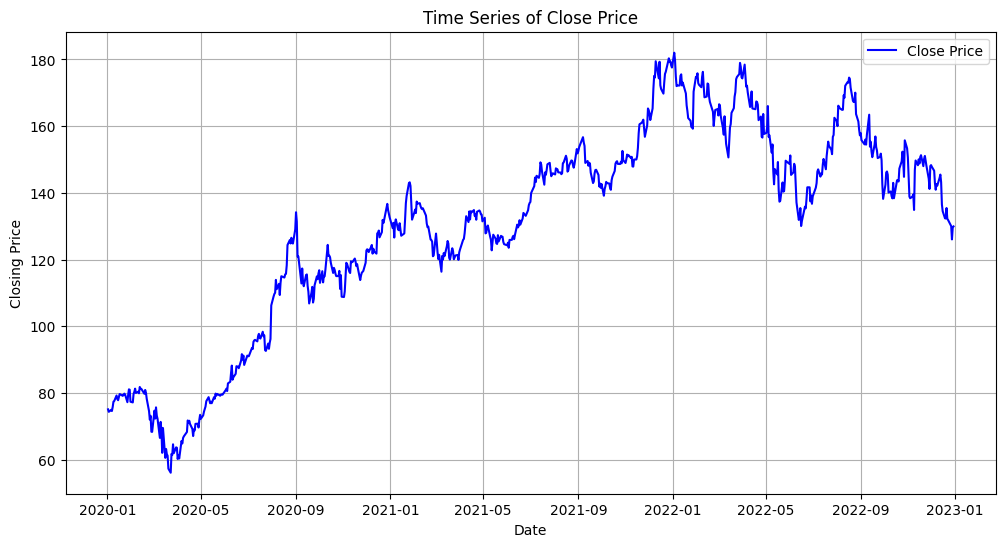

In [9]:
# Plot the time series closing price data
plt.figure(figsize=(12, 6))

plt.plot(stock_data['Close'], label='Close Price', color='blue')

plt.title('Time Series of Close Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

plt.legend()
plt.show()

In [10]:
# Perform Augmented Dickey-Fuller (ADF) test for stationarity
adf_test_df = stock_data[['Close']].copy()
perform_adf_test(adf_test_df['Close'])

ADF Test Results:
ADF Statistic: -1.8953789647960475
P-value: 0.33423810459018777
Lags Used: 1
Number of Observations Used: 754

Critical Values:
	1%: -3.439052522969989
	5%: -2.8653808299915013
	10%: -2.5688152592363274

Fail to reject the null hypothesis. The data is not stationary.


In [11]:
# Perform first-order differencing (d=1)
adf_test_df['Close_diff'] = adf_test_df['Close'].diff()

# Drop any missing values created by differencing
adf_test_df.dropna(inplace=True)

# Perform the ADF test on the differenced data
perform_adf_test(adf_test_df['Close_diff'])

ADF Test Results:
ADF Statistic: -29.171003879088016
P-value: 0.0
Lags Used: 0
Number of Observations Used: 754

Critical Values:
	1%: -3.439052522969989
	5%: -2.8653808299915013
	10%: -2.5688152592363274

Reject the null hypothesis. The data is stationary.


<Axes: xlabel='Date'>

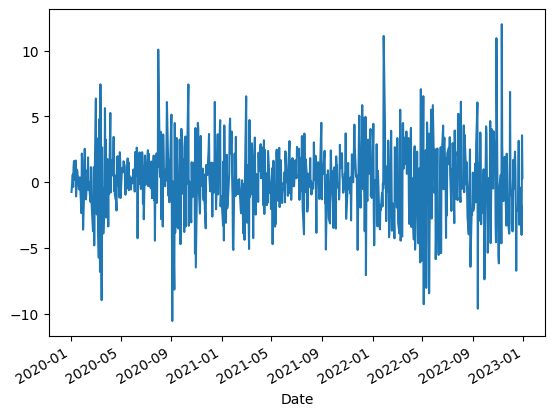

In [12]:
adf_test_df['Close_diff'].plot()

In [13]:
# Plot Autocorrelation and Partial Autocorrelation functions to identify p and q values.
# plot_acf_pacf(stock_data['Close'], acf_lags=80, pacf_lags=40, figsize=(10, 6))

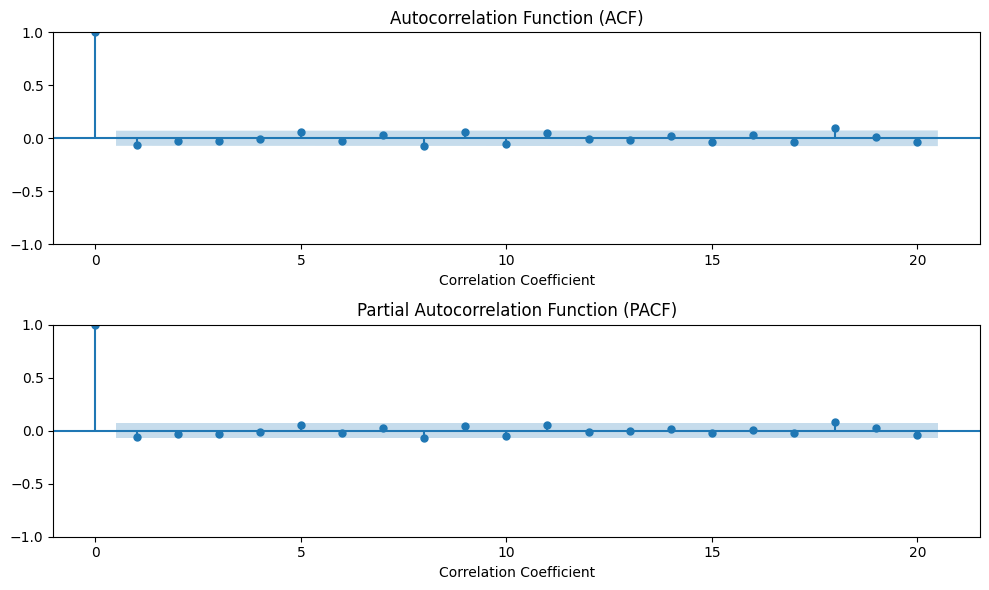

In [14]:
plot_acf_pacf(adf_test_df['Close_diff'], acf_lags=20, pacf_lags=20, figsize=(10, 6))

## 1.3. Split Data

In [15]:
# Split the data into a training set and a test set
train_data, test_data = train_test_split(stock_data, train_size=0.8)

# Print the number of data points in each set
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

Number of training samples: 604
Number of testing samples: 152


# 2. Build Model

## 2.1. Baseline

In [16]:
train_mean = train_data['Close'].mean()
pred_baseline = [train_mean] * len(train_data)
mae_baseline = metrics.mean_absolute_error(train_data['Close'], pred_baseline)

print("Train Mean: {}".format(train_mean.round(2)))
print("Baseline MAE: {}".format(mae_baseline.round(2)))

Train Mean: 125.74
Baseline MAE: 26.12


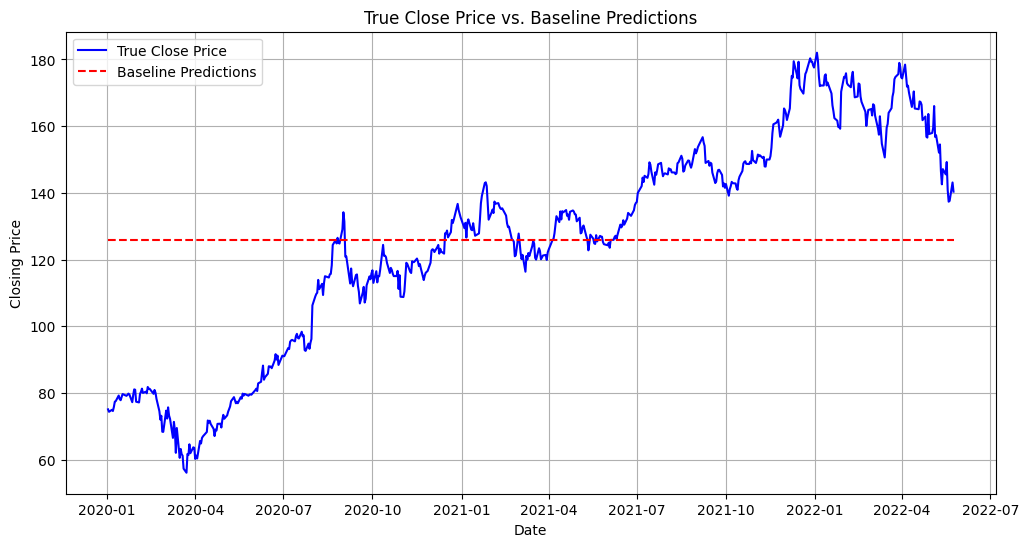

In [17]:
# Plot closing price data with baseline (mean) predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], label='True Close Price', color='blue')
plt.plot(train_data.index, pred_baseline, label='Baseline Predictions', color='red', linestyle='--')

# Set labels and title
plt.title('True Close Price vs. Baseline Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

## 2.2. ARIMA Model

### 2.2.1 Train

In [18]:
# Fit the ARIMA model to the training data
order = (0, 1, 0)
model = sm.tsa.ARIMA(train_data['Close'].values, order=order).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  604
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1442.420
Date:                Fri, 08 Sep 2023   AIC                           2886.840
Time:                        07:34:38   BIC                           2891.242
Sample:                             0   HQIC                          2888.554
                                - 604                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.0025      0.305     22.994      0.000       6.406       7.599
Ljung-Box (L1) (Q):                   3.98   Jarque-Bera (JB):                61.20
Prob(Q):                              0.05   Pr

In [19]:
# Grid search for best order

p_values = [0, 1, 2, 3]
q_values = [0, 1, 2]

best_p, best_q, best_mae, mae_grid = grid_search_arima(train_data['Close'], p_values=p_values, q_values=q_values)

Order = (0, 1, 0), MAE=2.0791, Elapsed Time=0.04 seconds
Order = (0, 1, 1), MAE=2.072, Elapsed Time=0.1 seconds
Order = (0, 1, 2), MAE=2.0721, Elapsed Time=0.13 seconds
Order = (1, 1, 0), MAE=2.0717, Elapsed Time=0.07 seconds
Order = (1, 1, 1), MAE=2.0718, Elapsed Time=0.13 seconds
Order = (1, 1, 2), MAE=2.0709, Elapsed Time=0.36 seconds
Order = (2, 1, 0), MAE=2.0717, Elapsed Time=0.09 seconds
Order = (2, 1, 1), MAE=2.0721, Elapsed Time=0.76 seconds
Order = (2, 1, 2), MAE=2.0706, Elapsed Time=0.59 seconds
Order = (3, 1, 0), MAE=2.07, Elapsed Time=0.14 seconds
Order = (3, 1, 1), MAE=2.0693, Elapsed Time=0.33 seconds
Order = (3, 1, 2), MAE=2.0549, Elapsed Time=1.87 seconds


In [20]:
print("Best p:", best_p)
print("Best q:", best_q)
print("Best MAE:", best_mae)

Best p: 3
Best q: 2
Best MAE: 2.0549


In [21]:
# Convert the mae_grid dictionary to a DataFrame for Seaborn
mae_df = pd.DataFrame(mae_grid)
# mae_df

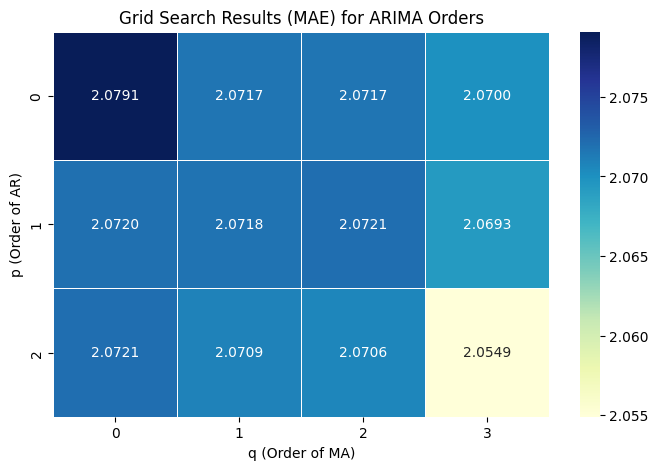

In [22]:
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(mae_df, annot=True, cmap="YlGnBu", fmt=".4f", linewidths=0.5)

# Add labels and title
plt.xlabel('q (Order of MA)')
plt.ylabel('p (Order of AR)')
plt.title('Grid Search Results (MAE) for ARIMA Orders')

# Show the plot
plt.show()

### 2.2.2 Prediction

In [23]:
order = (3,1,2)
prediction_1 = walk_forward_arima(train_data['Close'], test_data['Close'], order, suppress_warnings=True)

1: 2022-05-25 True value: 140.52, Predicted value: 140.7294
2: 2022-05-26 True value: 143.78, Predicted value: 139.9412
3: 2022-05-27 True value: 149.64, Predicted value: 142.4784
4: 2022-05-31 True value: 148.84, Predicted value: 149.2189
5: 2022-06-01 True value: 148.71, Predicted value: 148.4622
6: 2022-06-02 True value: 151.21, Predicted value: 149.1793
7: 2022-06-03 True value: 145.38, Predicted value: 150.9381
8: 2022-06-06 True value: 146.14, Predicted value: 145.4892
9: 2022-06-07 True value: 148.71, Predicted value: 146.3625
10: 2022-06-08 True value: 147.96, Predicted value: 148.5870
11: 2022-06-09 True value: 142.64, Predicted value: 147.7175
12: 2022-06-10 True value: 137.13, Predicted value: 143.2111
13: 2022-06-13 True value: 131.88, Predicted value: 137.3293
14: 2022-06-14 True value: 132.76, Predicted value: 132.0000
15: 2022-06-15 True value: 135.43, Predicted value: 132.9821
16: 2022-06-16 True value: 130.06, Predicted value: 135.2290
17: 2022-06-17 True value: 131.56

## 2.3. Auto_ARIMA Model

In [24]:
# Find the best ARIMA model using auto_arima
best_model = pm.auto_arima(
    train_data['Close'],
    seasonal=False,           # Set to True if your data has a seasonal component
    stepwise=True,            # Enable stepwise search
    suppress_warnings=True,   # Suppress warnings for convergence issues
    error_action="ignore",    # Ignore errors during the search
    max_order=None,           # Set maximum order (p, d, q) for ARIMA
    trace=True                # Print progress and results
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2891.218, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2887.831, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2885.852, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2885.825, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2886.840, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2887.797, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2887.819, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2889.640, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2885.037, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2887.045, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2887.036, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2885.047, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2888.824, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.571 seconds


In [25]:
prediction_2 = walk_forward_arima(train_data['Close'], test_data['Close'], best_model.order, suppress_warnings=True)

1: 2022-05-25 True value: 140.52, Predicted value: 140.5440
2: 2022-05-26 True value: 143.78, Predicted value: 140.5219
3: 2022-05-27 True value: 149.64, Predicted value: 143.5201
4: 2022-05-31 True value: 148.84, Predicted value: 149.1821
5: 2022-06-01 True value: 148.71, Predicted value: 148.8656
6: 2022-06-02 True value: 151.21, Predicted value: 148.7218
7: 2022-06-03 True value: 145.38, Predicted value: 151.0218
8: 2022-06-06 True value: 146.14, Predicted value: 145.8246
9: 2022-06-07 True value: 148.71, Predicted value: 146.1152
10: 2022-06-08 True value: 147.96, Predicted value: 148.5040
11: 2022-06-09 True value: 142.64, Predicted value: 148.0033
12: 2022-06-10 True value: 137.13, Predicted value: 143.0653
13: 2022-06-13 True value: 131.88, Predicted value: 137.5531
14: 2022-06-14 True value: 132.76, Predicted value: 132.2373
15: 2022-06-15 True value: 135.43, Predicted value: 132.7267
16: 2022-06-16 True value: 130.06, Predicted value: 135.2564
17: 2022-06-17 True value: 131.56

# 3. Interpret

In [26]:
mae_baseline.round(4)

26.1162

In [27]:
evaluation_metric(test_data['Close'].values,prediction_1)

Evaluation Results:
MSE: 11.44929
RMSE: 3.38368
MAE: 2.61246
R2: 0.89887


In [29]:
evaluation_metric(test_data['Close'].values,prediction_2)

Evaluation Results:
MSE: 11.00734
RMSE: 3.31773
MAE: 2.55677
R2: 0.90277


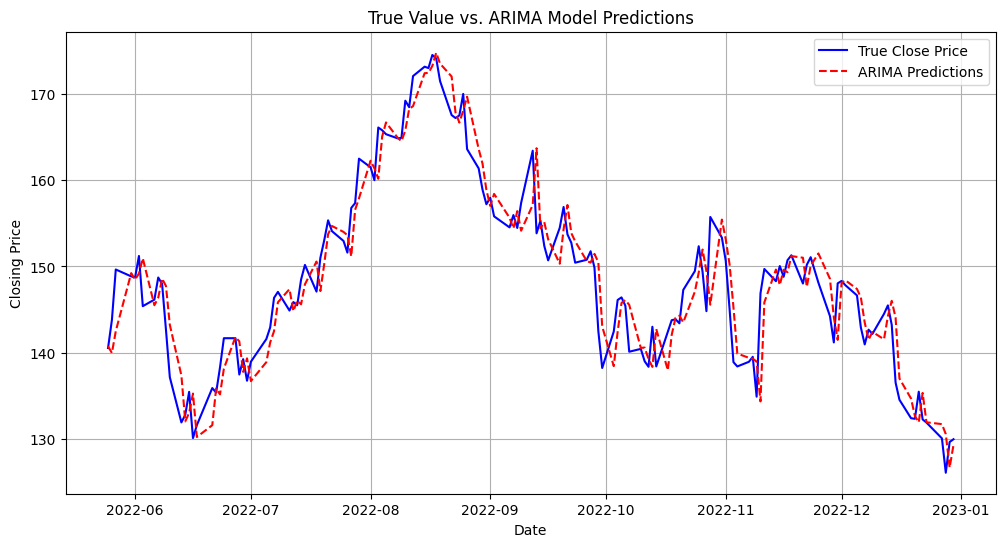

In [30]:
# Plot closing price data with ARIMA model predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Close'], label='True Close Price', color='blue')
plt.plot(test_data.index, prediction_1, label='ARIMA Predictions', color='red', linestyle='--')

# Set labels and title
plt.title('True Value vs. ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

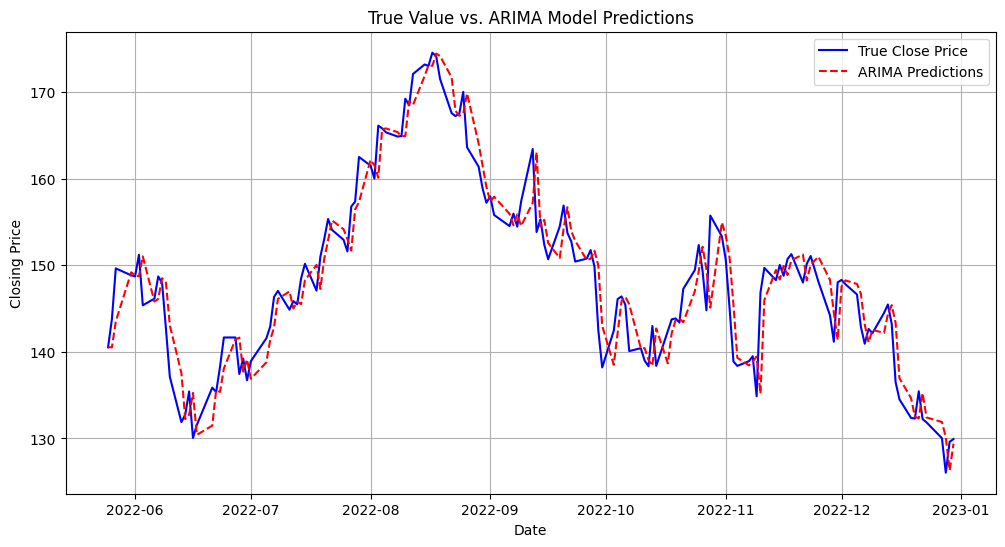

In [31]:
# Plot closing price data with ARIMA model predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Close'], label='True Close Price', color='blue')
plt.plot(test_data.index, prediction_2, label='ARIMA Predictions', color='red', linestyle='--')

# Set labels and title
plt.title('True Value vs. ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [32]:
model = sm.tsa.ARIMA(stock_data['Close'].values, order=(0, 1, 1)).fit()
residuals = model.resid

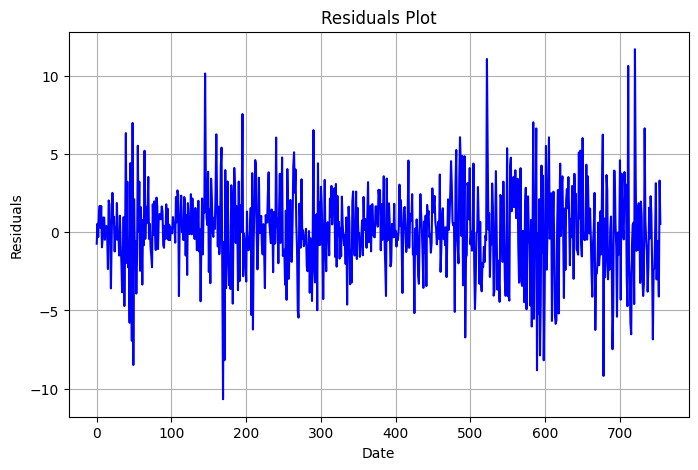

In [33]:
# Residuals Plot
plt.figure(figsize=(8, 5))
plt.plot(residuals[1:], color='blue')
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

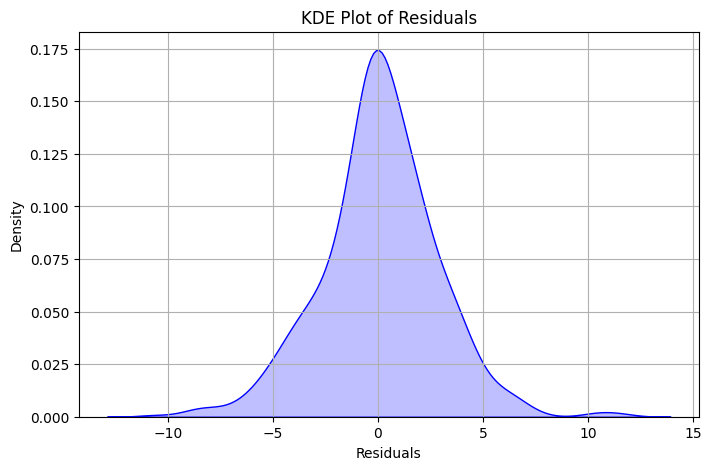

In [34]:
plt.figure(figsize=(8, 5))
sns.kdeplot(residuals[1:], color='blue', fill=True)
plt.title('KDE Plot of Residuals')
plt.xlabel('Residuals')
plt.grid(True)
plt.show()

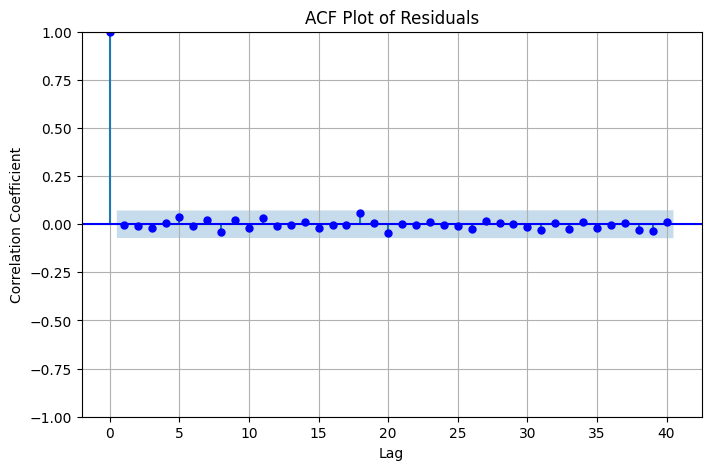

In [35]:
plt.figure(figsize=(8, 5))
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=plt.gca(), color='blue')
plt.title('ACF Plot of Residuals')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

# Application: Trading

In [40]:
arima_prediction_trade = pd.DataFrame(
    {
        'Actual': test_data['Close'].round(2),
        'Predicted': prediction_2
    },
    index=test_data.index
)

In [41]:
arima_prediction_trade.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Actual,Predicted
Date,,
2022-05-25,140.52,140.544034
2022-05-26,143.78,140.521916
2022-05-27,149.64,143.520141
2022-05-31,148.84,149.182055
2022-06-01,148.71,148.865586


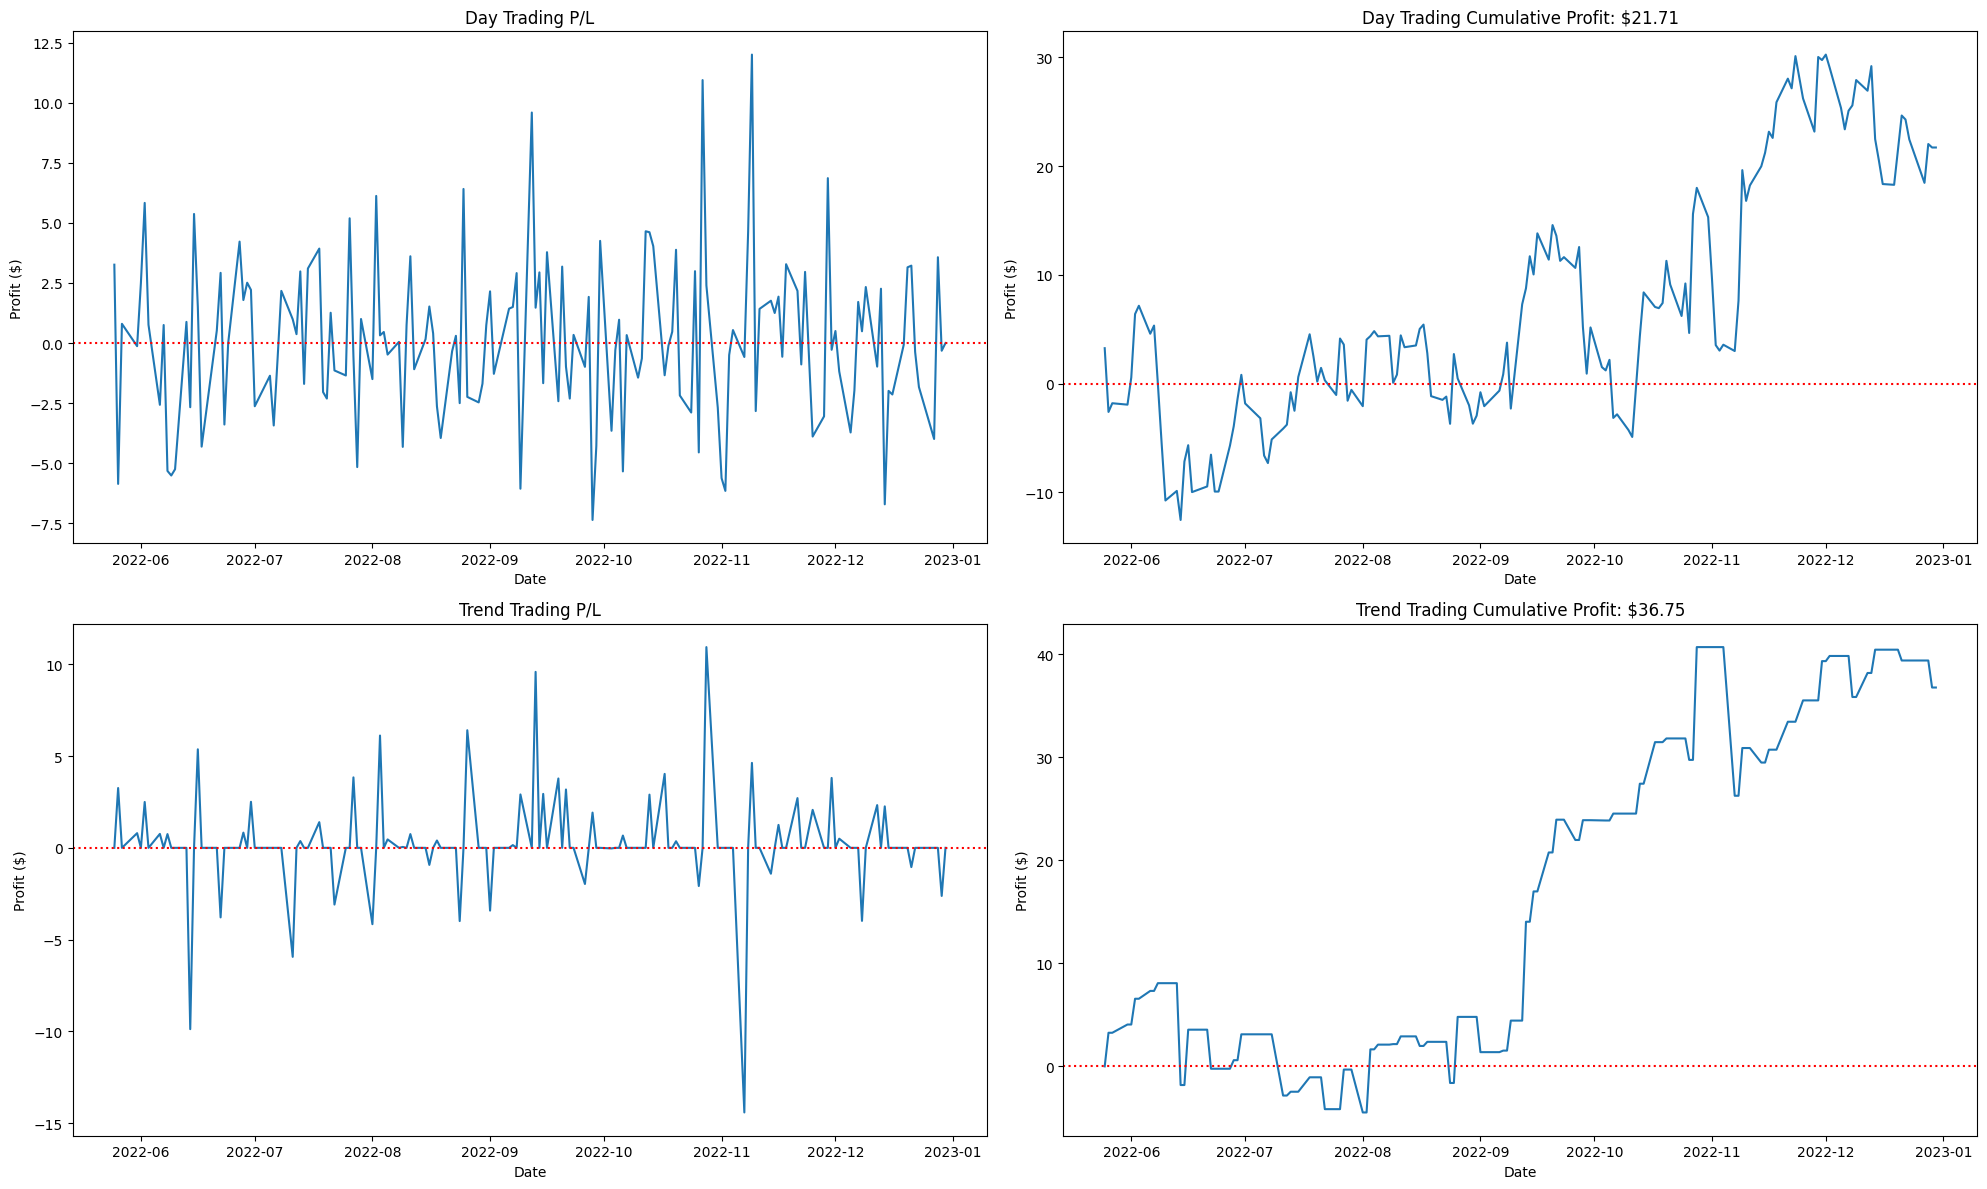

In [42]:
# Apply the functions using .pipe
arima_prediction_trade = (
    arima_prediction_trade
    .pipe(calculate_trade_actions)
    .pipe(simulate_day_trade)
    .pipe(simulate_trend_trade)
)

# Plot the combined trading results
plot_combined_trading_results(arima_prediction_trade)

In [43]:
arima_prediction_trade.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Actual,Predicted,ActualTradeAction,PredictedTradeAction,Profit_Day,CumulativeProfit_Day,TradePosition,TempPrice,Profit_Trend,CumulativeProfit_Trend
Date,,,,,,,,,,
2022-05-25,140.52,140.544034,Buy,Buy,3.26,3.26,Start Buy,140.52,0.00,0.00
2022-05-26,143.78,140.521916,Buy,Sell,-5.86,-2.60,Close Position,143.78,3.26,3.26
2022-05-27,149.64,143.520141,Sell,Sell,0.80,-1.80,Start Sell,149.64,0.00,3.26
2022-05-31,148.84,149.182055,Sell,Buy,-0.13,-1.93,Close Position,148.84,0.80,4.06
2022-06-01,148.71,148.865586,Buy,Buy,2.50,0.57,Start Buy,148.71,0.00,4.06


# Export As Excel

In [46]:
# Create an ExcelWriter object to save multiple DataFrames into one Excel file
excel_file_path = 'ARIMA_Model.xlsx'
with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as excel_writer:

    # Save 'stock_data' DataFrame to the first sheet
    stock_data.to_excel(excel_writer, sheet_name='Stock_Data', index=True)

    # Save 'arima_residual' DataFrame to the second sheet
    order = (0, 1, 0)
    model = sm.tsa.ARIMA(train_data['Close'].values, order=order).fit()

    arima_train_residual = pd.DataFrame(
        {
            'Actual': train_data['Close'],
            'Predicted': model.predict(),
            'Residuals': model.resid
        },
        index=train_data.index
    )
    arima_train_residual.to_excel(excel_writer, sheet_name='ARIMA_Train_Residuals', index=True)

    # Save 'arima_prediction' DataFrame to the third sheet
    arima_prediction = pd.DataFrame(
        {
            'Actual': test_data['Close'],
            'Predicted': prediction_2
        },
        index=test_data.index
    )
    arima_prediction.to_excel(excel_writer, sheet_name='ARIMA_Prediction', index=True)

    # Save 'arima_prediction_trade' DataFrame to the fourth sheet
    arima_prediction_trade.to_excel(excel_writer, sheet_name='ARIMA_Trade', index=True)

print(f"Combined data saved to {excel_file_path}")

Combined data saved to ARIMA_Model.xlsx
